In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Loading all data into DataFrame

In [2]:
def load_data():
    path = Path('data')
    dataframe = []
    for folder in path.iterdir():
        activity = str(folder.name)
        data = pd.concat((pd.read_csv(file) for file in folder.iterdir()), ignore_index=True)
        data['activity'] = activity
        dataframe.append(data)
    dataframe = pd.concat(dataframe)
    dataframe.to_pickle('all_data.pkl')
    
if not Path('all_data.pkl').is_file():
    load_data()
df = pd.read_pickle('all_data.pkl')

In [3]:
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle


In [4]:
df.describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


In [5]:
activities = df['activity'].unique()
attributes = df.columns.to_list()
attributes.remove('activity')
print(activities, attributes)

['idle' 'running' 'stairs' 'walking'] ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']


In [6]:
def heatmap_plot(model_name, conf_mat):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Part 1. Training SVC and RFC on raw data

In [7]:
# train test split
X = df.drop('activity', axis = 1)
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4)

In [8]:
%%time
svc = SVC().fit(X_train, y_train)
y_test_predicted_svc = svc.predict(X_test)

CPU times: total: 11min 53s
Wall time: 12min 30s


In [9]:
%%time
rfc = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)
y_test_predicted_rfc = rfc.predict(X_test)

CPU times: total: 6.91 s
Wall time: 7.18 s


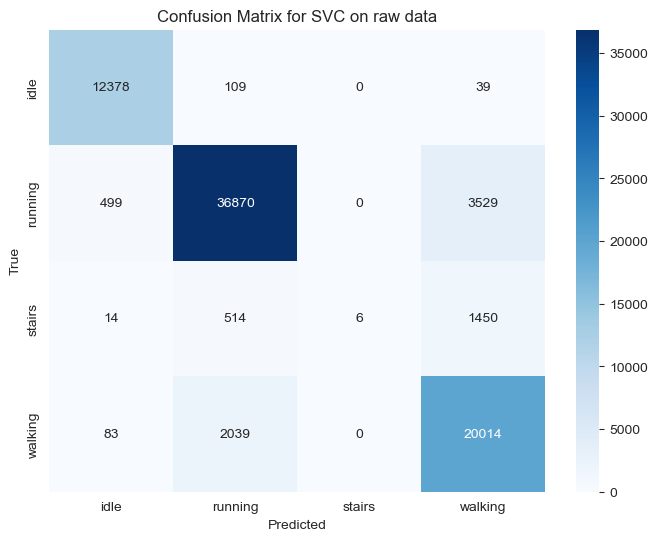

              precision    recall  f1-score   support

        idle       0.95      0.99      0.97     12526
     running       0.93      0.90      0.92     40898
      stairs       1.00      0.00      0.01      1984
     walking       0.80      0.90      0.85     22136

    accuracy                           0.89     77544
   macro avg       0.92      0.70      0.69     77544
weighted avg       0.90      0.89      0.88     77544


In [10]:
svc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_svc)
svc_classification_report = classification_report(y_test, y_test_predicted_svc)
heatmap_plot("SVC on raw data", svc_confusion_matrix)
print(svc_classification_report)

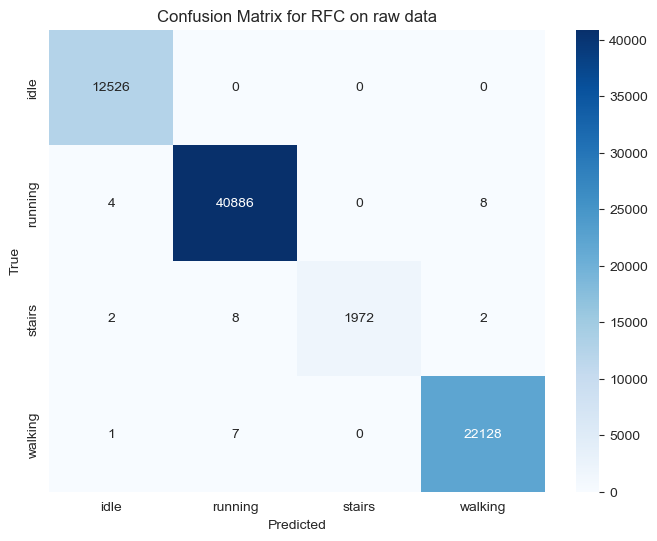

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00     12526
     running       1.00      1.00      1.00     40898
      stairs       1.00      0.99      1.00      1984
     walking       1.00      1.00      1.00     22136

    accuracy                           1.00     77544
   macro avg       1.00      1.00      1.00     77544
weighted avg       1.00      1.00      1.00     77544


In [11]:
rfc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_rfc)
rfc_classification_report = classification_report(y_test, y_test_predicted_rfc)
heatmap_plot("RFC on raw data", rfc_confusion_matrix)
print(rfc_classification_report)

# Part 2. Training SVC and RFC on time domain features data

In [38]:
# Building time domain features dataframe
def entropy(data):
    hist, bins = np.histogram(data, bins='auto')
    probs = hist / len(data)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def interquartile_range(data):
    return data.quantile(0.75) - data.quantile(0.25)

def mean_of_absolute_deviation(data):
    return abs(data - data.mean()).mean()

def root_mean_square_error(data):
    mean = np.mean(data)
    squared_errors = [(x - mean) ** 2 for x in data]
    return np.sqrt(np.mean(squared_errors))

def idxmin(data): # fix issue with idxmin from pandas
    return np.argmin(data)


attr_agg_funcs = {
    'accelerometer_X': ['max', 'min', entropy, interquartile_range],
    'accelerometer_Y': ['max', idxmin, mean_of_absolute_deviation, 'median', 'skew','std', root_mean_square_error],
    'accelerometer_Z': ['skew']
}

time_domain_features = df.groupby(["activity", df.index// 50]).agg(attr_agg_funcs) 
time_domain_features.reset_index(level=0, inplace=True)
time_domain_features.head()

activity accelerometer_X                                          \
                       max       min   entropy interquartile_range   
0     idle        5.099650 -0.909797  3.109675            0.061052   
1     idle        0.488417 -0.191536  2.868059            0.040701   
2     idle        0.560243  0.268151  2.622683            0.047885   
3     idle        0.560243  0.268151  2.711231            0.047885   
4     idle        0.560243  0.268151  2.717922            0.043096   

  accelerometer_Y                                                        \
              max idxmin mean_of_absolute_deviation    median      skew   
0        4.616021      2                   0.353354 -0.129287  4.814225   
1        0.244209      7                   0.143269  0.210690 -0.570181   
2        0.086191     18                   0.036852 -0.019154 -1.086890   
3        0.086191     24                   0.032806 -0.019154 -0.867348   
4        0.086191      2                   0.032201 -0.026336 -1.206709   

                                   accelerometer_Z  
        std root_mean_square_error            skew  
0  0.903715               0.894632       -3.279397  
1  0.153039               0.151501       -0.219022  
2  0.055049               0.054495        0.490050  
3  0.047460               0.046983        0.581889  
4  0.051055               0.050542        0.465670

In [39]:
X = time_domain_features[attributes]
y = time_domain_features['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [40]:
%%time
svc = SVC(kernel="linear").fit(X_train, y_train)
y_test_predicted_svc = svc.predict(X_test)

CPU times: total: 78.1 ms
Wall time: 79 ms


In [41]:
%%time
rfc = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)
y_test_predicted_rfc = rfc.predict(X_test)

CPU times: total: 344 ms
Wall time: 354 ms


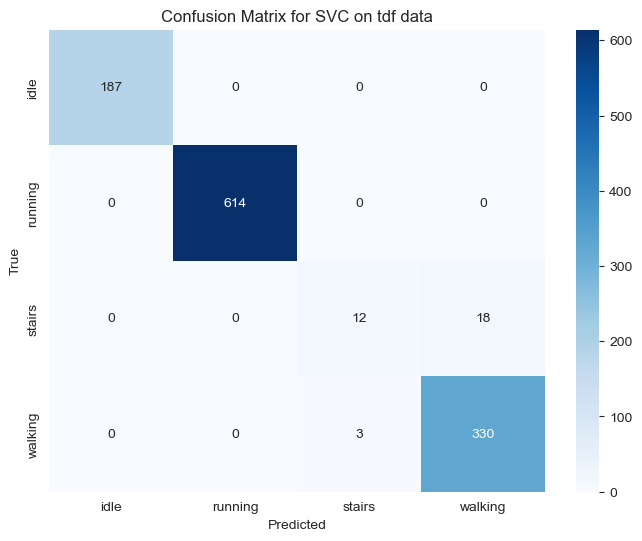

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       187
     running       1.00      1.00      1.00       614
      stairs       0.80      0.40      0.53        30
     walking       0.95      0.99      0.97       333

    accuracy                           0.98      1164
   macro avg       0.94      0.85      0.88      1164
weighted avg       0.98      0.98      0.98      1164


In [42]:
svc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_svc)
svc_classification_report = classification_report(y_test, y_test_predicted_svc)
heatmap_plot("SVC on tdf data", svc_confusion_matrix)
print(svc_classification_report)

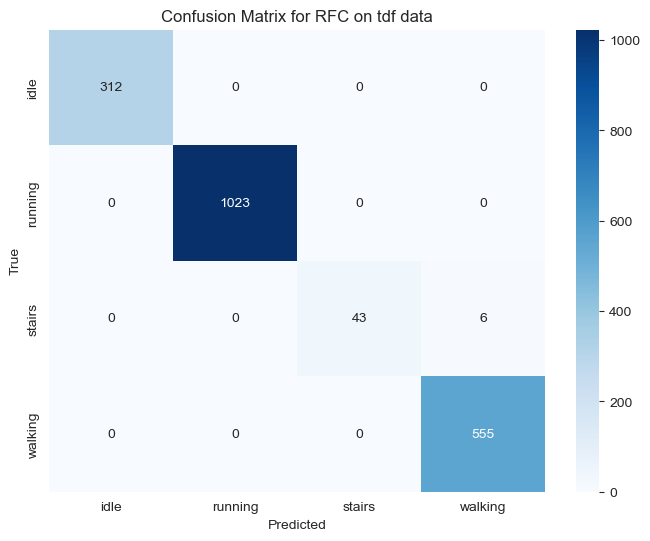

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       312
     running       1.00      1.00      1.00      1023
      stairs       1.00      0.88      0.93        49
     walking       0.99      1.00      0.99       555

    accuracy                           1.00      1939
   macro avg       1.00      0.97      0.98      1939
weighted avg       1.00      1.00      1.00      1939


In [36]:
rfc_confusion_matrix = confusion_matrix(y_test, y_test_predicted_rfc)
rfc_classification_report = classification_report(y_test, y_test_predicted_rfc)
heatmap_plot("RFC on tdf data", rfc_confusion_matrix)
print(rfc_classification_report)